# Metodo Sparse General


`
pip install numpy
pip install scipy
pip install cython
pip install sparsesvd
`

In [1]:
# Cargar herramientas para manejo de video
from video_tools import load_video, save_demo_video, save_video
import numpy as np
import matplotlib.pyplot as plt
from sparsesvd import sparsesvd
#import scipy.sparse
#from scipy.sparse.linalg import norm as sparse_norm
%matplotlib inline

In [2]:
import time

start = time.time()
print('Started Loading Video')

D, video_size = load_video("mini_trafico.avi")

print('Finished Loading Video')
print(time.time() - start)

Started Loading Video
Finished Loading Video
1.1938068866729736


In [13]:
def augmented_lagrangian(L, S, Y, mu, lamb, D):
    nuc = np.linalg.norm(L, ord='nuc')
    l1 = np.linalg.norm(S.flatten(), ord=1)
    tmp = D - L - S
    frob = np.linalg.norm(tmp, ord='fro')
    return nuc + lamb * l1 + np.sum(Y * tmp) + 0.5 * mu * frob ** 2


def J(Y, lamb):
    #if not scipy.sparse.issparse(Y):
    #    Y = scipy.sparse.csc_matrix(Y)
    Y_norm = np.linalg.norm(Y)
    return max(Y_norm, 1/lamb * Y_norm)


def soft_threshold(X, eps):
    out = np.zeros(X.shape)
    out[X > eps] = X[X > eps] - eps
    out[X < -eps] = X[X < -eps] + eps
    return out


def video_segmentation(D, max_iter=500, mu_0=0.001, lamb=0.01):
    Y_k = D / J(D, lamb)
    S_k = np.zeros(D.shape)
    #S_k = D - Y_k

    err = [] 
    for i in range(1, max_iter):
        mu_k = mu_0 * i  # mu_i crece de forma lineal

        print("Iteracion {}".format(i))
        # Resolver L_{k+1} = argmin_L L(L, S_k, Y_k, mu_k)
        tmp = D - S_k + (1 / mu_k) * Y_k
        #print('Converting to sparse')
        #tmp = scipy.sparse.csc_matrix(tmp)
        
        print("Starting SVD")
        U, S, V = np.linalg.svd(D - S_k + (1 / mu_k) * Y_k, full_matrices=False)
        print("Applying Soft-threshold")
        S_shrink = soft_threshold(S, (1 / mu_k))
        L_k = np.dot(U * S_shrink, V)

        # Resolver S_{k+1} = argmin_S L(L_k, S, Y_k, mu_k)
        S_k = soft_threshold(D - L_k + (1 / mu_k) * Y_k , lamb / mu_k)
        
        print("Updating Y_k")
        # Paso en valor del dual
        Y_k += mu_k * (D - L_k - S_k)
        print(augmented_lagrangian(L=L_k, S=S_k, lamb=lamb, mu=mu_k, Y=Y_k, D=D))

        err.append(np.linalg.norm(D - L_k - S_k, ord='fro') / np.linalg.norm(D, ord='fro'))
        if err[-1] < 1e-10:
            print('Method converged in iteration {}'.format(i))
            break


    L = L_k.copy()
    S = S_k.copy()
    
    return L, S, err

In [19]:
import time

start = time.time()
print('Started video segmentation')

L, S, err = video_segmentation(D, max_iter=500, mu_0=.1, lamb=0.001)

print('Finished video segmentation')
print(time.time() - start)

Started video segmentation
Iteracion 1
Starting SVD
Applying Soft-threshold
Updating Y_k
1052351.89223
Iteracion 2
Starting SVD
Applying Soft-threshold
Updating Y_k
1051926.20641
Iteracion 3
Starting SVD
Applying Soft-threshold
Updating Y_k
1051563.20862
Iteracion 4
Starting SVD
Applying Soft-threshold
Updating Y_k
1051291.03648
Iteracion 5
Starting SVD
Applying Soft-threshold
Updating Y_k
1051073.34644
Iteracion 6
Starting SVD
Applying Soft-threshold
Updating Y_k
1050891.97111
Iteracion 7
Starting SVD
Applying Soft-threshold
Updating Y_k
1050736.53081
Iteracion 8
Starting SVD
Applying Soft-threshold
Updating Y_k
1050600.53915
Iteracion 9
Starting SVD
Applying Soft-threshold
Updating Y_k
1050479.6724
Iteracion 10
Starting SVD
Applying Soft-threshold
Updating Y_k
1050370.90429
Iteracion 11
Starting SVD
Applying Soft-threshold
Updating Y_k
1050272.0341
Iteracion 12
Starting SVD
Applying Soft-threshold
Updating Y_k
1050181.41143
Iteracion 13
Starting SVD
Applying Soft-threshold
Updating Y

# Plot error

El criterio de convergencia del Liu no aplica porque la igualdad $L+S=D$ se cumple desde muy temprano en el algoritmo

Text(0.5,1,'Error relativo en norma Frobenius (Liu)')

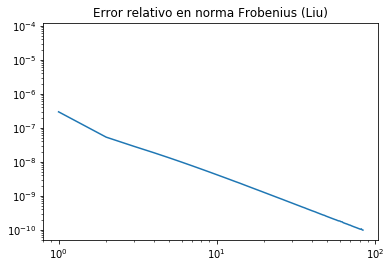

In [20]:
plt.loglog(err)
plt.title('Error relativo en norma Frobenius (Liu)')

# Ejemplos de frames del resultado

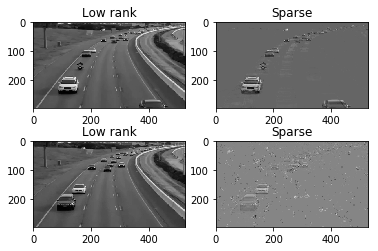

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.subplot('221')
plt.title('Low rank')
plt.imshow(L[:, 0].reshape(video_size), cmap='gray')

plt.subplot('222')
plt.title('Sparse')
plt.imshow(S[:, 0].reshape(video_size), cmap='gray')

plt.subplot('223')
plt.title('Low rank')
plt.imshow(L[:, 50].reshape(video_size), cmap='gray')

plt.subplot('224')
plt.title('Sparse')
plt.imshow(S[:, 50].reshape(video_size), cmap='gray')

# Save Video

In [22]:
import cv2
import numpy as np

save_video('test_output_2.avi', video_size, D, L, S)

Creating Video
Releasing Video


Started video segmentation
Iteracion 1
Starting SVD
Applying Soft-threshold
Updating Y_k
970901.718809
Iteracion 2
Starting SVD
Applying Soft-threshold
Updating Y_k
910475.049009
Iteracion 3
Starting SVD
Applying Soft-threshold
Updating Y_k
849544.50663
Iteracion 4
Starting SVD
Applying Soft-threshold
Updating Y_k
798975.787924
Iteracion 5
Starting SVD
Applying Soft-threshold
Updating Y_k
759903.30105
Iteracion 6
Starting SVD
Applying Soft-threshold
Updating Y_k
729061.190424
Iteracion 7
Starting SVD
Applying Soft-threshold
Updating Y_k
703566.836416
Iteracion 8
Starting SVD
Applying Soft-threshold
Updating Y_k
681825.434244
Iteracion 9
Starting SVD
Applying Soft-threshold
Updating Y_k
663202.414299
Iteracion 10
Starting SVD
Applying Soft-threshold
Updating Y_k
647888.940458
Iteracion 11
Starting SVD
Applying Soft-threshold
Updating Y_k
634827.187505
Iteracion 12
Starting SVD
Applying Soft-threshold
Updating Y_k
623686.391589
Iteracion 13
Starting SVD
Applying Soft-threshold
Updating Y

Applying Soft-threshold
Updating Y_k
575864.137458
Iteracion 108
Starting SVD
Applying Soft-threshold
Updating Y_k
575863.660512
Iteracion 109
Starting SVD
Applying Soft-threshold
Updating Y_k
575863.197289
Iteracion 110
Starting SVD
Applying Soft-threshold
Updating Y_k
575862.748132
Iteracion 111
Starting SVD
Applying Soft-threshold
Updating Y_k
575862.312496
Iteracion 112
Starting SVD
Applying Soft-threshold
Updating Y_k
575861.889129
Iteracion 113
Starting SVD
Applying Soft-threshold
Updating Y_k
575861.478372
Iteracion 114
Starting SVD
Applying Soft-threshold
Updating Y_k
575861.07813
Iteracion 115
Starting SVD
Applying Soft-threshold
Updating Y_k
575860.68837
Iteracion 116
Starting SVD
Applying Soft-threshold
Updating Y_k
575860.309097
Iteracion 117
Starting SVD
Applying Soft-threshold
Updating Y_k
575859.9402
Iteracion 118
Starting SVD
Applying Soft-threshold
Updating Y_k
575859.580517
Iteracion 119
Starting SVD
Applying Soft-threshold
Updating Y_k
575859.230733
Iteracion 120
Sta

Updating Y_k
575847.120553
Iteracion 213
Starting SVD
Applying Soft-threshold
Updating Y_k
575847.079055
Iteracion 214
Starting SVD
Applying Soft-threshold
Updating Y_k
575847.038458
Iteracion 215
Starting SVD
Applying Soft-threshold
Updating Y_k
575846.998844
Iteracion 216
Starting SVD
Applying Soft-threshold
Updating Y_k
575846.96036
Iteracion 217
Starting SVD
Applying Soft-threshold
Updating Y_k
575846.922931
Iteracion 218
Starting SVD
Applying Soft-threshold
Updating Y_k
575846.886019
Iteracion 219
Starting SVD
Applying Soft-threshold
Updating Y_k
575846.849698
Iteracion 220
Starting SVD
Applying Soft-threshold
Updating Y_k
575846.813898
Iteracion 221
Starting SVD
Applying Soft-threshold
Updating Y_k
575846.778752
Iteracion 222
Starting SVD
Applying Soft-threshold
Updating Y_k
575846.744141
Iteracion 223
Starting SVD
Applying Soft-threshold
Updating Y_k
575846.710069
Iteracion 224
Starting SVD
Applying Soft-threshold
Updating Y_k
575846.676721
Iteracion 225
Starting SVD
Applying So

575845.224975
Iteracion 318
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.218085
Iteracion 319
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.211295
Iteracion 320
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.204547
Iteracion 321
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.197915
Iteracion 322
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.191376
Iteracion 323
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.184928
Iteracion 324
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.178557
Iteracion 325
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.172226
Iteracion 326
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.165997
Iteracion 327
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.159853
Iteracion 328
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.153786
Iteracion 329
Starting SVD
Applying Soft-threshold
Updating Y_k
575845.147755
Iteracion 330
Starting SVD
Applying Soft-threshold

Starting SVD
Applying Soft-threshold
Updating Y_k
575844.82319
Iteracion 424
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.821518
Iteracion 425
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.819854
Iteracion 426
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.818224
Iteracion 427
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.816624
Iteracion 428
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.815054
Iteracion 429
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.813512
Iteracion 430
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.811996
Iteracion 431
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.810503
Iteracion 432
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.809027
Iteracion 433
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.807535
Iteracion 434
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.806063
Iteracion 435
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.80461
It

Updating Y_k
575844.716062
Iteracion 529
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.715468
Iteracion 530
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.714879
Iteracion 531
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.714296
Iteracion 532
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.713717
Iteracion 533
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.713144
Iteracion 534
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.712575
Iteracion 535
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.712011
Iteracion 536
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.711452
Iteracion 537
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.710897
Iteracion 538
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.710346
Iteracion 539
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.709799
Iteracion 540
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.709255
Iteracion 541
Starting SVD
Applying S

Iteracion 634
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.676779
Iteracion 635
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.676609
Iteracion 636
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.676442
Iteracion 637
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.676275
Iteracion 638
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.67611
Iteracion 639
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.675946
Iteracion 640
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.675783
Iteracion 641
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.675621
Iteracion 642
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.675461
Iteracion 643
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.675302
Iteracion 644
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.675143
Iteracion 645
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.674986
Iteracion 646
Starting SVD
Applying Soft-threshold
Updating Y_k
5

Applying Soft-threshold
Updating Y_k
575844.667763
Iteracion 740
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.667745
Iteracion 741
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.667729
Iteracion 742
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.667714
Iteracion 743
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.667699
Iteracion 744
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.667685
Iteracion 745
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.667672
Iteracion 746
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.66766
Iteracion 747
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.667648
Iteracion 748
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.667637
Iteracion 749
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.667627
Iteracion 750
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.667617
Iteracion 751
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.667608
Iteracion 752


Updating Y_k
575844.669005
Iteracion 845
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.669037
Iteracion 846
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.669068
Iteracion 847
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.6691
Iteracion 848
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.669132
Iteracion 849
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.669165
Iteracion 850
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.669197
Iteracion 851
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.66923
Iteracion 852
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.669264
Iteracion 853
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.669297
Iteracion 854
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.669331
Iteracion 855
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.669365
Iteracion 856
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.6694
Iteracion 857
Starting SVD
Applying Soft-t

Iteracion 950
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.673729
Iteracion 951
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.673782
Iteracion 952
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.673836
Iteracion 953
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.673889
Iteracion 954
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.673943
Iteracion 955
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.673997
Iteracion 956
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.674051
Iteracion 957
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.674105
Iteracion 958
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.67416
Iteracion 959
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.674214
Iteracion 960
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.674269
Iteracion 961
Starting SVD
Applying Soft-threshold
Updating Y_k
575844.674323
Iteracion 962
Starting SVD
Applying Soft-threshold
Updating Y_k
5

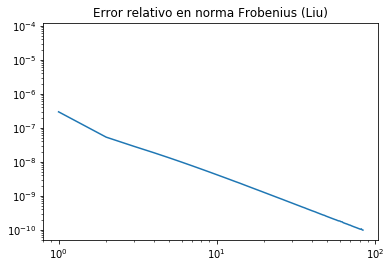

In [30]:
def video_segmentation_2(D, max_iter=500, mu_0=0.001, lamb=0.01):
    Y_k = D / J(D, lamb)
    S_k = np.zeros(D.shape)
   # S_k = D - Y_k

    err = [] 
    for i in range(1, max_iter):
        #mu_k = mu_0 * i**2  # mu_i crece de forma cuadratica
        mu_k = mu_0
        
        print("Iteracion {}".format(i))
        # Resolver L_{k+1} = argmin_L L(L, S_k, Y_k, mu_k)
        tmp = D - S_k + (1 / mu_k) * Y_k
        #print('Converting to sparse')
        #tmp = scipy.sparse.csc_matrix(tmp)
        
        print("Starting SVD")
        U, S, V = np.linalg.svd(D - S_k + (1 / mu_k) * Y_k, full_matrices=False)
        print("Applying Soft-threshold")
        S_shrink = soft_threshold(S, (1 / mu_k))
        L_k = np.dot(U * S_shrink, V)

        # Resolver S_{k+1} = argmin_S L(L_k, S, Y_k, mu_k)
        S_k = soft_threshold(D - L_k + (1 / mu_k) * Y_k , lamb / mu_k)
        
        print("Updating Y_k")
        # Paso en valor del dual
        Y_k += mu_k * (D - L_k - S_k)
        print(augmented_lagrangian(L=L_k, S=S_k, lamb=lamb, mu=mu_k, Y=Y_k, D=D))

        err.append(np.linalg.norm(D - L_k - S_k, ord='fro') / np.linalg.norm(D, ord='fro'))
        if err[-1] < 1e-10:
            print('Method converged in iteration {}'.format(i))
            break


    L = L_k.copy()
    S = S_k.copy()
    
    return L, S, err

start = time.time()
print('Started video segmentation')

L2, S2, err2 = video_segmentation_2(D, max_iter=1000, mu_0=.001, lamb=0.001)

print('Finished video segmentation')
print(time.time() - start)

plt.loglog(err)
plt.title('Error relativo en norma Frobenius (Liu)')

save_video('test_output_3.avi', video_size, D, L2, S2)